In [1]:
import numpy as np
import torch
import ot
from ot.datasets import make_1D_gauss as gauss
from sparse_ot.matroid_col_k import get_gamma
from sparse_ot.sparse_repr_autok import get_gamma as get_gamma_k
from sparse_ot.uot_mmd import solve_apgd as get_gamma_orig
from sparse_ot.utils import get_G, get_dist, offd_dist, postprocess_gamma
import ot.plot
import matplotlib.pyplot as plt
from matplotlib import gridspec

In [2]:
m, n = 10, 10
device = torch.device("cuda")
x = torch.arange(m).float().to(device)
y = torch.arange(n).float().to(device)

a = torch.from_numpy(gauss(m, 5, 1)).float().to(device)
b = torch.from_numpy(gauss(n, 5, 1)).float().to(device)
v = {1: a, 2: b}

K = 10
max_itr = 1000

def get_cost_G(x, y, khp, ktype, p=2):
    # None means taking median-heuristic
    C = get_dist(x, y, p)
    C = C/C.max()
    
    G1 = get_G(x=x, y=x, khp=khp, ktype=ktype)
    G2 = get_G(x=y, y=y, khp=khp, ktype=ktype)
    G = {1: G1, 2: G2}
    return C, G

khp = 1
ktype = "rbf"
C, G = get_cost_G(x, y, khp=khp, ktype=ktype)
lda = 100

In [3]:
def plot1D_mat(a, b, M, title=''):
    na, nb = M.shape

    gs = gridspec.GridSpec(3, 3)

    xa = np.arange(na)
    xb = np.arange(nb)

    ax1 = plt.subplot(gs[0, 1:])
    plt.plot(xb, b, 'r', label='Target distribution')
    plt.yticks(())
    plt.title(title)

    ax2 = plt.subplot(gs[1:, 0])
    plt.plot(a, xa, 'b', label='Source distribution')
    plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()
    plt.xticks(())

    plt.subplot(gs[1:, 1:], sharex=ax1, sharey=ax2)
    plt.imshow(M, interpolation='nearest', cmap="hot")
    plt.axis('off')

    plt.xlim((0, nb))
    plt.tight_layout()
    plt.subplots_adjust(wspace=0., hspace=0.2)

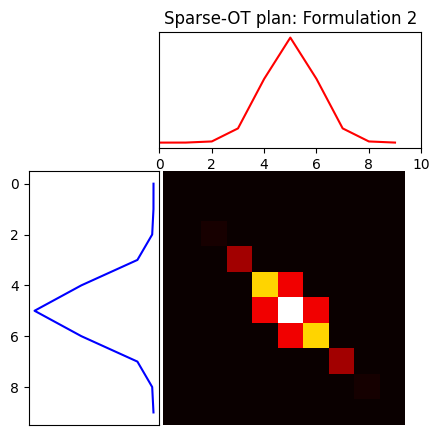

In [4]:
gamma, S_i, S_j = get_gamma(C, G[1], G[2], v[1], v[2], max_itr, K, lda)
gamma = postprocess_gamma(gamma, S_i, S_j, m, n)

plt.figure(1, figsize=(4.5, 4.5))
plot1D_mat(v[1].cpu().numpy(), v[2].cpu().numpy(), gamma.cpu().numpy(), f"Sparse-OT plan: Formulation 2")
plt.show()

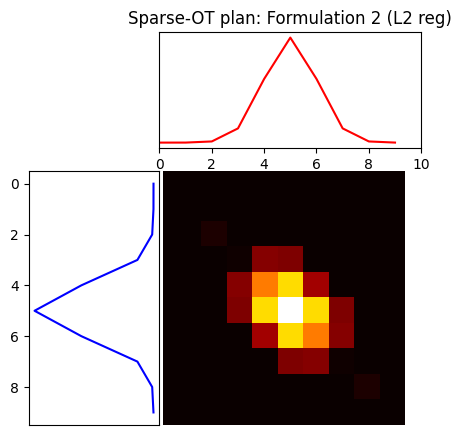

In [5]:
gamma, S_i, S_j = get_gamma(C, G[1], G[2], v[1], v[2], max_itr, K, lda, lda3=1)
gamma = postprocess_gamma(gamma, S_i, S_j, m, n)

plt.figure(1, figsize=(4.5, 4.5))
plot1D_mat(v[1].cpu().numpy(), v[2].cpu().numpy(), gamma.cpu().numpy(), f"Sparse-OT plan: Formulation 2 (L2 reg)")
plt.show()

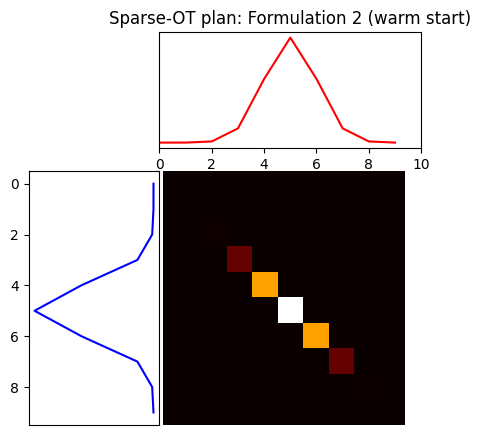

In [6]:
gamma, S_i, S_j = get_gamma(C, G[1], G[2], v[1], v[2], max_itr, K, lda, ws=1)
gamma = postprocess_gamma(gamma, S_i, S_j, m, n)

plt.figure(1, figsize=(4.5, 4.5))
plot1D_mat(v[1].cpu().numpy(), v[2].cpu().numpy(), gamma.cpu().numpy(), f"Sparse-OT plan: Formulation 2 (warm start)")
plt.show()

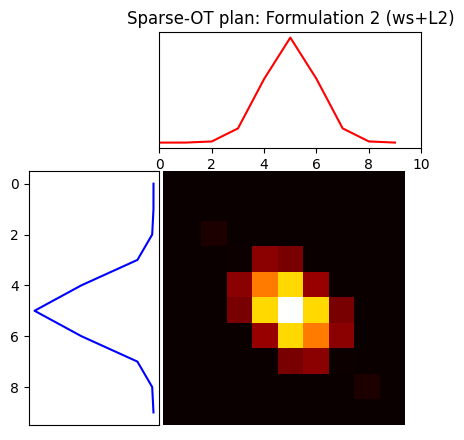

In [7]:
gamma, S_i, S_j = get_gamma(C, G[1], G[2], v[1], v[2], max_itr, K, lda, lda3=1, ws=1)
gamma = postprocess_gamma(gamma, S_i, S_j, m, n)

plt.figure(1, figsize=(4.5, 4.5))
plot1D_mat(v[1].cpu().numpy(), v[2].cpu().numpy(), gamma.cpu().numpy(), f"Sparse-OT plan: Formulation 2 (ws+L2)")
plt.show()

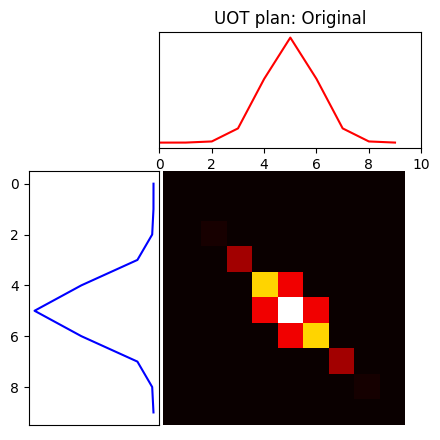

In [7]:
gamma = get_gamma_orig(C, G[1], G[2], v[1], v[2], max_itr, lda)

plt.figure(1, figsize=(4.5, 4.5))
plot1D_mat(v[1].cpu().numpy(), v[2].cpu().numpy(), gamma.cpu().numpy(), f"UOT plan: Original")
plt.show()